# A crash course in useful patterns and practices for building a Gantry demo

This notebook uses a silly example to provide you with some basic tools useful in constructing a Gantry product demo. Below, we'll cover
1. Exploring datasets
2. Simulating user behavior
3. Generating predictions with a pretrained ML model
4. Simulating a pattern of user feedback
5. Logging image data to Gantry

With a basic handle on the above, you will be well set-up to explore some of your own ideas, test things out with teamates, and iterate your way to a great demo.

For now, we're keeping this tutorial simple, restricted only to the above: this notebook does not constitute a valid, complete Gantry demo. Currently, it's more of a technical "how to," but we will frame things around a demo idea.

## CaptiveCaption

*Recommend the best caption for an image, given a list of candidates*

CaptiveCaption is an ML-powered service built for and used by a (fake) website where users upload picutres and add generally unimaginative captions to them. CaptiveCaption ranks image captions using similarity score relevance and recommends the best caption, typically the most literal or informative one. The top-ranking caption is then displayed on the website, but users can up/downvote the suggested caption.

The site has become popular with boring animal lovers who write dry captions, but recently there's been an increase in downvotes for the captions suggested by CaptiveCaption. Investigation will show that this is due to many more cat photos coming through lately. We'll find that the model tends to prefer a more literal description for the cat photos than users, who prefer humorous captions for cats. Ultimately, we'll send these photos off for expert labeling and improve the model's sense of humor.

* INPUTS: Simulate user-provided caption candidates with `"ydshieh/vit-gpt2-coco-en"`, an image-to-text model.
* OUTPUTS: Rank candidates image-text pairs using `"nvidia/groupvit-gcc-redcaps"` and recommend a best caption
* FEEDBACK: When it's a cat photo, and the true label isn't the top rank, we'll add "downvoted" feedback.

* Log to Gantry
  * images
  * recommended best caption
  * best captions relevance score
  * timestams witrh recent increase in cats
  * more downvote feedback for cat photos

In [1]:
%load_ext lab_black
%matplotlib inline

import datetime
import os
from pathlib import Path
import requests
import urllib
import uuid
import warnings

from cloudpathlib import CloudPath
import datasets
from dotenv import dotenv_values
from faker import Faker
import gantry
from IPython import display
from loguru import logger
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tempfile
from transformers import AutoProcessor, GroupViTModel, pipeline, set_seed
from tqdm import tqdm

# Ignore some annoying transformer warnings
warnings.filterwarnings("ignore")

In [2]:
config = dotenv_values("../.env")

# For sending data to s3
os.environ["AWS_PROFILE"] = config.get("AWS_PROFILE", "sandbox")

# For logging to Gantry
GANTRY_API_KEY = config.get("GANTRY_API_KEY_STAGING")
if not GANTRY_API_KEY:
    raise ValueError("Set your Gantry API key!")

# For logging to non-prod Gantry
if config.get("GANTRY_LOGS_LOCATION"):
    os.environ["GANTRY_LOGS_LOCATION"] = config.get("GANTRY_LOGS_LOCATION")
    logger.info(f"Set Gantry logging location: {os.environ['GANTRY_LOGS_LOCATION']}")

# Wrap column text in Pandas
pd.set_option("display.max_colwidth", 0)

2023-01-28 19:24:54.431 | INFO     | __main__:<module>:14 - Set Gantry logging location: https://app.staging.gantry.io


# Explore the data

First, let's stream a subset of data that we can use for our demo. We'll be using the [Red Caps](https://huggingface.co/datasets/red_caps) dataseet from Hugging Face because it has real image-caption pairs from Reddit that we can use as a basis for simulating users, generating predictions, feedback, and more. Plus, Hugging Face hosts some  odels trained on this dataset, as we'll see below.

> RedCaps is a large-scale dataset of 12M image-text pairs collected from Reddit. Images and captions from Reddit depict and describe a wide variety of objects and scenes. The data is collected from a manually curated set of subreddits (350 total), which give coarse image labels and allow steering of the dataset composition without labeling individual instances. RedCaps data is created by the people, for the people – it contains everyday things that users like to share on social media, for example hobbies (r/crafts) and pets (r/shiba). Captions often contain specific and fine-grained descriptions (northern cardinal, taj mahal). Subreddit names provide relevant image labels (r/shiba) even when captions may not (mlem!), and sometimes may group many visually unrelated images through a common semantic meaning (r/perfectfit).

**12 Million** is a lot of pairs, so let's stream the dataset.

In [3]:
HF_DATASET_NAME = "red_caps"
CAT_SUBSET = "cats"  # subsets listed on dataset page
ALL_ANIMALS_SUBSET = "alltheanimals"


cats_streamed = datasets.load_dataset(
    HF_DATASET_NAME,
    CAT_SUBSET,
    split="train",  # we can choose any valid split
    streaming=True,
)

animals_streamed = datasets.load_dataset(
    HF_DATASET_NAME,
    ALL_ANIMALS_SUBSET,
    split="train",  # we can choose any valid split
    streaming=True,
)

Make the data more user-friendly by `.take`ing some into a Pandas DataFrame.

**NOTE: The `DEV_SAMPLE` constant can be used for notebook development.**

In [4]:
######## SET T0 FALSE FOR LARGER SAMPLE ########
DEV_SAMPLE = True
################################################

NUM_CAT_SAMPLES = 200
NUM_ANIMALS_SAMPLES = 300

cat_df = pd.DataFrame([record for record in cats_streamed.take(NUM_CAT_SAMPLES)])
cat_df["is_cat"] = True

animal_df = pd.DataFrame(
    [record for record in animals_streamed.take(NUM_ANIMALS_SAMPLES)]
)
animal_df["is_cat"] = False

df = pd.concat([cat_df, animal_df], axis=0).sample(frac=1, random_state=0)

if DEV_SAMPLE:
    df = df.sample(50)

df.head()

,image_id,author,image_url,raw_caption,caption,subreddit,score,created_utc,permalink,crosspost_parents,is_cat
50,dhnn87,grettaaa,https://i.redd.it/o4mu3dr3vgs31.png,The happiest tree frog uwu,the happiest tree frog uwu,4,20,1571041430,/r/ALLTHEANIMALS/comments/dhnn87/the_happiest_tree_frog_uwu/,None,False
161,dvzhjx,Umbra_Venit,https://i.redd.it/wh0ocd6e4jy31.jpg,My arm is now a cat,my arm is now a cat,4,12,1573683811,/r/ALLTHEANIMALS/comments/dvzhjx/my_arm_is_now_a_cat/,None,False
151,dupgu0,3dness,https://i.redd.it/l935m954o0y31.jpg,Perfect couple!!!,perfect couple!!!,4,33,1573460423,/r/ALLTHEANIMALS/comments/dupgu0/perfect_couple/,None,False
178,f9abf,None,http://i.imgur.com/7uo5E.jpg,We gotta be sneaky Charlie...sneaky!,we gotta be sneaky charlie...sneaky!,85,23,1296036788,/r/cats/comments/f9abf/we_gotta_be_sneaky_charliesneaky/,None,True
44,dhh7op,grettaaa,https://i.redd.it/wsey4w1brds31.jpg,We've reached over 600 members !!! 🙏🙏🎉🎉 Thank you to all of you for making it happen,we've reached over 600 members !!! thank you to all of you for making it happen,4,7,1571003781,/r/ALLTHEANIMALS/comments/dhh7op/weve_reached_over_600_members_thank_you_to_all_of/,None,False


Some urls might not exist exists. Let's get rid of the ones that don't.

In [5]:
def image_exists(row, new_col="image_exists"):
    try:
        urllib.request.urlopen(row.image_url)
        row[new_col] = True
    except Exception as e:
        row[new_col] = False
    return row


tqdm.pandas(desc="Check for urls")
df = df.progress_apply(image_exists, axis=1)
num_failed = (~df.image_exists).sum()
logger.info(f"{num_failed} of {len(df)} image urls failed. Dropping {num_failed}...")
df = df[df.image_exists].reset_index(drop=True)  # avoid weird index errors

Check for urls: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.47it/s]
2023-01-28 19:25:23.009 | INFO     | __main__:<module>:13 - 8 of 50 image urls failed. Dropping 8...


## Look at images!

In [6]:
def show_image(url, width=300):
    image = Image.open(requests.get(url, stream=True).raw)
    if width:
        ratio = width / image.width
        height = int(image.height * ratio)
        image = image.resize((width, height), Image.LANCZOS)
    return image


def show_image_caption_pair(idx=0):
    print(df.caption[idx])
    return show_image(df.image_url[idx])

baron catticus von karma bids you good day


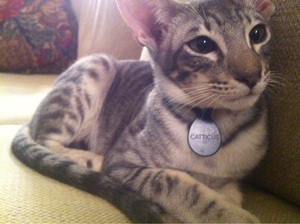

In [7]:
show_image_caption_pair(np.random.choice(len(df)))

tibetan fox vs a startled marmot


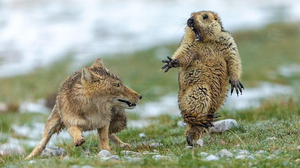

In [8]:
show_image_caption_pair(np.random.choice(len(df)))

the happiest tree frog uwu


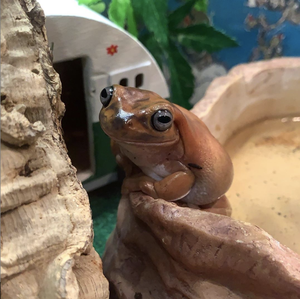

In [9]:
show_image_caption_pair(np.random.choice(len(df)))

$245.70 2.5" blade of grass up my cats nose :(


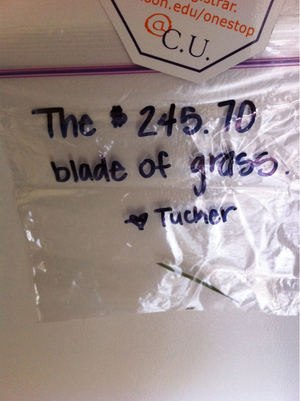

In [10]:
show_image_caption_pair(np.random.choice(len(df)))

# Simulate user captions

This is all well and good, but remember, our model ranks captions provided by users to suggest the best caption. This means **we need "user-submitted" captions to rank**. Since each image in the dataset only comes with one caption, we'll need to generate the others.

Once way we can do that is to use an ML model to generate alternatives for us!

Hugging Face [pipelines](https://huggingface.co/docs/transformers/pipeline_tutorial) make it easy to get going. Consider the following image.

In [11]:
num_captions_to_generate = 4
captioner = pipeline(
    "image-to-text",
    model="ydshieh/vit-gpt2-coco-en",
    model_kwargs={
        "num_return_sequences": num_captions_to_generate,
        "num_beams": num_captions_to_generate,
    },
)


def generate_captions(url, captioner=captioner):
    return [caption["generated_text"] for caption in captioner(url)]

massive buck walking through his territory


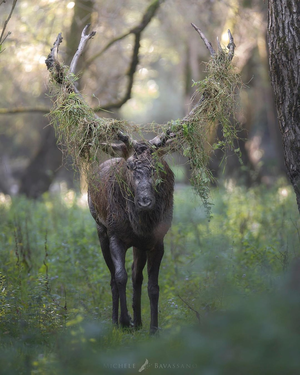

In [12]:
idx = 6
show_image_caption_pair(idx)

In [13]:
rec_captions = generate_captions(df.image_url[idx])
rec_captions

['a small animal standing in the middle of a forest ',
 'a small animal standing in the middle of a wooded area ',
 'a small animal standing in the middle of a field ',
 'a large brown animal standing in a forest ']

# Use model to rank user captions

[This model](https://huggingface.co/nvidia/groupvit-gcc-redcaps) computes similarity scores between text-image pairs. The text that is "the most similar" to the image is considered "the best caption."

In [14]:
PROCESSOR = AutoProcessor.from_pretrained("nvidia/groupvit-gcc-redcaps")
MODEL = GroupViTModel.from_pretrained("nvidia/groupvit-gcc-redcaps")


def rank_captions(captions, image_url, processor=PROCESSOR, model=MODEL):
    image = Image.open(requests.get(image_url, stream=True).raw)
    inputs = processor(
        text=captions,
        images=image,
        return_tensors="pt",
        padding=True,
    )
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1).squeeze().detach().numpy().tolist()
    results = {caption: prob for caption, prob in zip(captions, probs)}
    return dict(sorted(results.items(), key=lambda x: x[1], reverse=True))

Let's see how our captions are ranked.

In [15]:
ranked_captions = rank_captions(rec_captions, df.image_url[idx])
ranked_captions

{'a small animal standing in the middle of a forest ': 0.4757118225097656,
 'a large brown animal standing in a forest ': 0.2930389940738678,
 'a small animal standing in the middle of a wooded area ': 0.22517329454421997,
 'a small animal standing in the middle of a field ': 0.006075870245695114}

Add in the true caption

In [16]:
ranked_captions = rank_captions(
    rec_captions + [df.caption[idx]],
    df.image_url[idx],
)
ranked_captions

{'a small animal standing in the middle of a forest ': 0.44385644793510437,
 'a large brown animal standing in a forest ': 0.27341604232788086,
 'a small animal standing in the middle of a wooded area ': 0.2100948840379715,
 'massive buck walking through his territory': 0.0669635534286499,
 'a small animal standing in the middle of a field ': 0.00566900847479701}

In this example, the true caption is the lowest rank. It's this kind of pattern we want to exploit for negative feedback signals.

First, let's add our predictions to the dataset.

In [17]:
def get_best_caption(ranked_captions):
    best_caption_text = max(ranked_captions, key=ranked_captions.get)
    best_caption_prob = max(ranked_captions.values())
    return best_caption_text, best_caption_prob


get_best_caption(ranked_captions)

('a small animal standing in the middle of a forest ', 0.44385644793510437)

In [18]:
def add_preds_to_dataset(row):
    rec_captions = generate_captions(row.image_url)
    if row.is_cat:
        rec_captions.append(row.caption)
    ranked_captions = rank_captions(rec_captions, row.image_url)
    best_caption_text, best_caption_prob = get_best_caption(ranked_captions)
    row["best_caption_text"] = best_caption_text
    row["best_caption_prob"] = best_caption_prob
    return row


tqdm.pandas(desc="Add preds to dataset")
df = df.progress_apply(add_preds_to_dataset, axis=1)

Add preds to dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [02:07<00:00,  3.03s/it]


# Create feedback

For cat photos, when the best caption isn't the true caption, we'll downvote the caption. This simulates behavior in which users are dissatisfied with the caption.

In [19]:
def feedback_downvote_if_not_caption_for_cats(
    row, feedback_col="downvoted", join_key="uuid"
):
    if row.is_cat and (row.best_caption_text != row.caption):
        row[feedback_col] = True
    else:
        row[feedback_col] = False

    row[join_key] = str(uuid.uuid4())
    return row


df = df.apply(feedback_downvote_if_not_caption_for_cats, axis=1)
df.downvoted.mean()

0.35714285714285715

# Log to Gantry

## Send images to s3

Since this data includes images, we'll need to first send the images to s3. This is because currently, Gantry is configured to allow customers to log images by providing Gantry with s3 URIs via the logger and some limited read access policies that must be configured on the customer end.

Gantry employees can send images to the `gantry-customer-bucket-access-test-pdx` bucket using their `sandbox` profile. URIs from this bucket can be rendered in the Gantry front end.

Images can be moved to s3 in any number of ways, but we're going to use [cloudpathlib](https://cloudpathlib.drivendata.org/stable/) because the only thing better than `pathlib` is **`pathlib` in the cloud**.

In [20]:
####### CHANGE FOR YOUR USE CASE #######

MY_DEMO_PREFIX = "casey-captive-caption"

########################################


BUCKET_NAME = "gantry-customer-bucket-access-test-pdx"
BUCKET_PATH = CloudPath(f"s3://{BUCKET_NAME}")
assert BUCKET_PATH.exists()

DEMO_PATH = BUCKET_PATH / MY_DEMO_PREFIX
DEMO_PATH.mkdir(exist_ok=True)


# Add s3 URIs to DataFrame
IMAGE_URI_COL = "image_s3_uri"
df[IMAGE_URI_COL] = df.image_url.map(lambda url: str(DEMO_PATH / Path(url).name))


for _, row in tqdm(df.iterrows(), total=len(df)):
    with tempfile.NamedTemporaryFile() as temp:
        temp_path = Path(temp.name)
        urllib.request.urlretrieve(row.image_url, temp.name)
        with temp_path.open("rb") as image_file:
            image_bytes = image_file.read()
            with CloudPath(row[IMAGE_URI_COL]).open("wb") as cloud_image_file:
                cloud_image_file.write(image_bytes)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [01:16<00:00,  1.82s/it]


Now our data is in s3, and our Data Frame has the s3 uri we need to log to Gantry!

In [21]:
df[IMAGE_URI_COL].tolist()[:5]

['s3://gantry-customer-bucket-access-test-pdx/casey-captive-caption/o4mu3dr3vgs31.png',
 's3://gantry-customer-bucket-access-test-pdx/casey-captive-caption/wh0ocd6e4jy31.jpg',
 's3://gantry-customer-bucket-access-test-pdx/casey-captive-caption/l935m954o0y31.jpg',
 's3://gantry-customer-bucket-access-test-pdx/casey-captive-caption/7uo5E.jpg',
 's3://gantry-customer-bucket-access-test-pdx/casey-captive-caption/wsey4w1brds31.jpg']

## Controlling the data: add some timestamps and metadata

Often, we'll want to control *when*  or *where* our demo data "occurred." This allows us to say things like "Oh, we see that on Tuesday, Califronia users started rejecting our predicitons at a much higher rate. Something must be going on!"

The easiest way to add data like this, and lots of other cool fake stuff, is using the `faker` [library](https://faker.readthedocs.io/en/master/#basic-usage).

In [22]:
Faker.seed(9001)
faker = Faker()

# cat photos just started appearing yesterday
df["timestamp"] = None
df.loc[~df.is_cat, "timestamp"] = sorted(
    [
        faker.date_time_between(
            start_date="-3d",
            tzinfo=datetime.timezone.utc,
        )
        for _ in range((~df.is_cat).sum())
    ]
)
df.loc[df.is_cat, "timestamp"] = sorted(
    [
        faker.date_time_between(
            start_date="-1d",
            tzinfo=datetime.timezone.utc,
        )
        for _ in range((df.is_cat).sum())
    ]
)

df["timestamp"] = pd.to_datetime(df.timestamp, utc=True)

# random states for everyone
df["state"] = [faker.state() for _ in range(len(df))]

df[["timestamp", "state", "caption"]].head()

,timestamp,state,caption
0,2023-01-26 06:11:18+00:00,Missouri,the happiest tree frog uwu
1,2023-01-26 07:25:37+00:00,North Dakota,my arm is now a cat
2,2023-01-26 08:27:16+00:00,North Dakota,perfect couple!!!
3,2023-01-28 06:11:25+00:00,Louisiana,we gotta be sneaky charlie...sneaky!
4,2023-01-26 21:45:23+00:00,Idaho,we've reached over 600 members !!! thank you to all of you for making it happen


## Send bacthes to Gantry
Let's log to Gantry!

First, determine what columns to log

In [23]:
TIMESTAMP_COL = ["timestamp"]

INPUTS = ["uuid", IMAGE_URI_COL, "state"]

OUTPUTS = [
    "best_caption_text",
    "best_caption_prob",
]

FEEDBACK = ["downvoted"]

COLS_TO_KEEP = TIMESTAMP_COL + INPUTS + OUTPUTS + FEEDBACK

to_gantry = df[COLS_TO_KEEP]
to_gantry.head()

,timestamp,uuid,image_s3_uri,state,best_caption_text,best_caption_prob,downvoted
0,2023-01-26 06:11:18+00:00,6060ee19-6029-45d1-abb3-c9a37c47c025,s3://gantry-customer-bucket-access-test-pdx/casey-captive-caption/o4mu3dr3vgs31.png,Missouri,a small brown bird sitting on top of a wooden table,0.845603,False
1,2023-01-26 07:25:37+00:00,dd149029-8e7f-4aab-8f12-70be913a8ba3,s3://gantry-customer-bucket-access-test-pdx/casey-captive-caption/wh0ocd6e4jy31.jpg,North Dakota,a gray and white cat laying on top of a blanket,0.303621,False
2,2023-01-26 08:27:16+00:00,cf7a2036-8228-4836-b0ce-47ac346a08fa,s3://gantry-customer-bucket-access-test-pdx/casey-captive-caption/l935m954o0y31.jpg,North Dakota,a dog and a cat in a snowy field,0.421953,False
3,2023-01-28 06:11:25+00:00,a1e9c810-b579-408d-a47d-a93596b86ff9,s3://gantry-customer-bucket-access-test-pdx/casey-captive-caption/7uo5E.jpg,Louisiana,a cat laying in a box on a table,0.366430,True
4,2023-01-26 21:45:23+00:00,c68d07b9-72e2-4fa8-8412-40e38b0d71c7,s3://gantry-customer-bucket-access-test-pdx/casey-captive-caption/wsey4w1brds31.jpg,Idaho,a dog laying on a blanket with a hat on,0.340974,False


In [24]:
gantry.init(GANTRY_API_KEY)

gantry.log_records(
    application="casey-captive-caption",
    inputs=to_gantry[INPUTS],
    outputs=to_gantry[OUTPUTS],
    feedbacks=to_gantry[FEEDBACK],
    timestamps=to_gantry.timestamp.dt.to_pydatetime().tolist(),
    tags={"env": "dev-sample"},
    as_batch=True,
)

2023-01-28 19:29:16,112 gantry.logger.event_builder INFO     Processing 42 lines.
2023-01-28 19:29:16,114 gantry.logger.client INFO     Initializing upload to Gantry
2023-01-28 19:29:16,251 gantry.logger.utils INFO     Starting multipart upload
2023-01-28 19:29:16,887 gantry.logger.utils INFO     Multipart upload complete
2023-01-28 19:29:16,888 gantry.logger.client INFO     Starting Gantry Ingestion
2023-01-28 19:29:17,127 gantry.logger.utils INFO     Track your batch at https://app.staging.gantry.io/applications/casey-captive-caption/jobs
2023-01-28 19:29:17,128 gantry.logger.utils INFO     Look for batch id: 0868bb1f-fb88-45ad-aadd-bfb25e5fe600


('0868bb1f-fb88-45ad-aadd-bfb25e5fe600',
 ['1e5fa2fd-8b51-4717-ad77-58f67a95fe7c',
  'a257b51e-d1b8-48e6-a16e-bfe11167e48f',
  '4e93255d-fa8a-4048-872f-42777750bb07',
  '24008a49-a445-4bdb-b9ac-406c4c034001',
  '959603d8-85d8-4676-9c9b-1aa32958a060',
  '19255c6b-b52b-42cb-b61d-6a8ac65793dd',
  'c780d6e1-b689-4b0c-a3a0-c6a04960043d',
  '05f8bbad-a269-4b6a-b9e6-295fa26dc9ad',
  '05e2f873-abf1-4386-99e2-c7a97d5364d2',
  'd52b70c8-d24e-4790-9c82-78e9f6b0f300',
  'dd94f09a-c277-4a48-9530-4b635afdf144',
  '549bf054-b8fe-40d0-a0e1-ce84586004f3',
  'a17ed727-7368-43ff-8c6e-d44de2246c9c',
  'd50dc6c5-9265-449b-aeed-c9420877a000',
  'a4e66064-aea5-454f-b5c7-b8cf1d1b69a0',
  'a9efdeb2-e035-4c96-b97d-2c8932c6cacc',
  'b10ed2a9-18dc-4ca4-8e3c-df14d27c7189',
  'ac6649c9-29a5-4581-9432-1c820d60c3d9',
  '7ff6ea58-046a-445c-a88c-bf3dfafebebb',
  'ad87f4ed-d2c7-49bb-afa0-5f7de9ecf5ce',
  '1535dc80-6eef-4ef4-a8b6-6eaeb94c92f5',
  'e51915f7-c7f1-4e6e-96ce-2b2d63d2fbd3',
  'd684b416-7166-4b1d-8304-747ce693

# What's next?

- make the model interactive with `gradio`
- cache the processed results for faster demo deployment
- improve the strngth of the signal for the problem in Gantry
- **bonus** how do we curate a dataset of cat photos?